# EEG-ERP Preprocessing
---
## Learning Objectives
- Be able to describe the standard steps in preprocessing EEG data for ERP analysis, including filtering, visual inspection, automated artifact detection and removal using independent components analysis, bad channel removal and interpolation, re-referencing, and averaging
- Be able to describe the motivation for each of these preprocessing steps
- Be able to perform each preprocessing step using MNE

---

## Introduction
**Preprocessing** is a series of signal processing steps that are performed on data prior to analysis (EDA and/or statistical analysis) and interpretation. In virtually all forms of neuroimaging data, including EEG and MEG, preprocessing is necessary in order to remove noise and obtain a clean signal of interest. In the case of EEG, the data recorded from the scalp are inevitably a mixture of signals generated from the brain (which we likely care about), and other signals generated by sources other than the brain (which we generally don't wish to interpret). 

When they first learn about preprocessing, some people think it sounds a lot like cheating — "doctoring" or "cooking" the data to engineer a specific pattern of desired results. This is *not* the case, however. Preprocessing steps are carefully designed and implemented based on our understanding of the source and nature of particular sources of noise, as well as our understanding about the nature of the electrical activity generated by the brain. Because the skull is such a poor conductor of electricity, the amplitude of EEG signals recorded from the scalp is very small. In contrast, the amplitude of signals from noise sources — especially from the muscles and eyes — are often an order of magnitude or more larger. Thus if we fail to remove these known sources of noise from the data, it would be unlikely that we would detect the brain activity at all, and at best our ability to do so and make valid interpretations would be greatly diminished. In other words, ***preprocessing is an essential step in EEG analysis***.

In this lesson we will describe each standard step in preprocessing EEG data for ERP analysis, including why it is done, and how, using the MNE package. A script that runs a series of preprocessing steps on data is often called a **piepline**; often this term is used to also include the entire proces from transferring data from the EEG system to a server or other long-term storage, preprocessing, and statistical analysis. The present script is an example of a **preprocessing pieline**.

### Sources of noise in EEG

In EEG, sources of noise can be physiological and non-physiological.

**Physiological** sources of noise include muscles (especially face and neck muscles, which generate electrical potentials when contracting and relaxing), the eyes (which create distinctive signals both during blinks, and when the eyeballs move), and sometimes heartbeats (the heart produces strong, distinctive electrical signals as commonly measured with the electrocardiogram, or EKG) and breathing; the latter two sources typically are more of a problem for MEG than EEG data.

**Non-physiological** sources include artifacts generated when electrodes move relative to the scalp, when the electrode wires move, and ambient electromagnetic noise. Electromagnetic noise is created by virtually any device that uses electricity (except some battery-powered devices). In North America and some other parts of the world, **line voltage** — the alternating current that is provided through wired electrical outlets — oscillates at 60 Hz; in Europe and other parts of the world, line voltage alternates at 50 Hz. Thus depending on where the EEG data were recorded, they will likely contain a fairly distinct peak in the frequency spectrum at 50 or 60 Hz. While line noise is the most common source of electromagnetic interference, noise at other frequencies can also be produced by other equipment near the neuroimaging system (though sometimes this may be in another room or another floor of the building, and difficult to identify), or even stronger, transient sources (such as the 2-way radio of a passing truck).

We commonly refer to particular types of noise from known sources as **artifacts** in EEG. Thus you may see reference to *eye blink artifact*, *line noise artifact*, etc.. 

---

## Load packages

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

import numpy as np
import matplotlib.pyplot as plt

## Define experimental and preprocessing parameters

In the single unit chapter, we started the practice of defining experimental parameters as variables at the top of a notebook. This is good practice because the values are then defined when you need them. As well, it's good practice to define all of these parameters at the top of the file, rather than in the cell where you first need to use them. This is because, if later you want to change a parameter and re-run your notebook, it's easy to find all of the parameters, rather than scrolling through the script to find them. As well, when you report your results (e.g., in the Methods section of a paper), many of these parameters are things that you should include in your report. Defining them all at the top of a script makes it easy to find these values when you're writing up your study. 

<div class="alert alert-block alert-info">
<h3>Best practices in EEG/MEG reporting</h3>
    
Especially for people who are new to any field of neuroimaging, there can be an overwhelming array of technical information relating to how the data were collected, preprocessed, and analyzed. This can make it challenging to know how, or what, to report. Fortunately, leaders in the field have reached a general consensus on this, and have published guidelines for reporting EEG and MEG study results. The most recent of these is from [Pernet and colleagues (2020)](https://www.nature.com/articles/s41593-020-00709-0) and is endorsed by the Organization for Human Brain Mapping.    
    
</div> 

Below we define all the parameters we'll use in this preprocessing script. We'll explain them in more detail as we reach each step in the preprocessing pipeline.

In [2]:
# Participant ID code
p_id = 'P4'

# Electrode position file
montage = 'standard_1005'

# Filter settings
low_cut = 0.1
hi_cut  = 30
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'
filter_method = 'fir'

# ICA settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
ica_random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .995     # Specify n_components as a decimal to set % explained variance
ica_zthresh = 3.291     # USed to automatically determine which ICA components to reject 

# Event codes
event_id = {'video1':1, 'video2':2,
            'video3':3, 'video4':4,
            'video5':5, 'video6':6,
            'rest_start':7, 'rest':8,
           }

# Epoching settings
tmin = -1.0  # start of each epoch (in sec)
tmax =  1.0  # end of each epoch (in sec)
baseline = None  #(None, 0)
detrend = 0
reject = None
flat = None

## Import raw data

This is just the same as in the previous lesson

In [3]:
raw_file = 'data/' + p_id + '.vhdr'

raw = mne.io.read_raw_brainvision(raw_file, preload=True)

In this particular data set, the EEG cap was disconnected before the recording was stopped. This resulted in noise at the end of the file that doesn't reflect human EEG. This causes problems later, so we will crop the data here to prevent problems later.

In [4]:
raw.crop(tmax=1340);

## Set electrode positions

In [5]:
raw.set_montage(montage)

<RawBrainVision | P4.eeg, 16 x 670001 (1340.0 s), ~81.8 MB, data loaded>

## Filtering

As described in the previous section on [Time and Frequency Domains](./time_freq), a complex time-varying signal like EEG can be represented as a combination of sine waves of many different frequencies. Human EEG largely comprises signal power in a range of frequencies from 1–30 Hz; there is some evidence that higher frequencies may also carry important neurophysiological information, however in most EEG studies — and certainly in ERP studies — the vast majority of research questions concerns EEG signals in the 1–30 Hz frequency range. 

Sources of noise also manifest as oscillating frequencies that are picked up by EEG. In particular, *low frequency noise* comes from sources such as movement of the head and electrode wires, and perspiration on the scalp, while *high frequency noise* comes from sources including electromagnetic interference, and muscle contractions (especially facial and neck muscles). The frequency of these sources of noise may overlap with the 1-30 Hz EEG nad of interest, but in general they tend to be lower and higher, respectively, than human EEG. This means that by reducing the power of the signal at the frequencies above and below the range of experimental interest, we can reduce noise with minimal impact on the signals of interest. This process is called **filtering**.

Filtering typically occurs at two points in the EEG pipeline: first at the time the data are recorded, and secondly during preprocessing. When EEG data are collected, the EEG amplifier will at the very least have a filter that cuts off frequencies that are higher than a certain threshold. This is called the **low pass filter cutoff**, because the filter "passes" lower frequencies through, but attenuates (reduces) higher frequencies. A low pass filter is absolutely *necessary* during digital recording of EEG (or any signal), because of a phenomenon known as **aliasing**. This occurs when a high-frequency signal is sampled at a rate lower than the frequency of the signal, and the result is an artifact (an artificial signal that distorts our true signal) at a much lower frequency than the actual high-frequency source. 

### Aliasing

Simply knowing that aliasing causes high-frequency noise to be represented in the data as low-frequency artifacts — and that for this reason it's important to use a low-pass filter — is the most critical thing for someone doing EEG research. However, it's good to understand this phenomenon a little deeper. 

For example, in the current data set the EEG was recorded with a sampling rate of 500 Hz, meaning we obtained a measurement from each electrode every 2 ms. This is a sufficient sampling rate to detect an EEG signal at 30 Hz, because over the course of each cycle of the 30 Hz oscillation (e.g., from one peak to the next), which would last 1/30th of a second, we would have 500 / 30  $\approx$ 17 measurements of the waveform — so we should have enough samples to accurately reflect the shape of the oscillating sine wave. 

In contrast, imagine that during the recording, there was an electromagnetic (noise) signal present in the environment that oscillated at 1700 Hz. Thus in 1 second, the noise signal would have 1700 oscillations, but our EEG amplifier could not detect this, since it is only sampling 500 times per second. In fact, 3.4 oscillations of the noise waveform would occur between every sample acquired by the EEG amplifier. Since 1700 is not an even multiple of 500, each sample acquired by our EEG amplifier would also capture a different phase of the 17000 Hz oscillation — sometimes its peak, sometimes its trough, and sometimes somewhere in between. When we "connect the dots" between these samples to draw our measured EEG signal, these measurements at different points in the oscillation will end up looking like a much lower-frequency oscillation. **This is shown in the figure below.**

![aliasing figure]()

The highest frequency that one can accurately record at a given sampling rate is called the **Nyquist frequency**. This can be defined as either 1/2 or 1/3 of the sampling rate. In general, you should use 1/3 because it is safest. Using 1/2 is acceptable only if you can guarantee that your noise sources and your signal are *phase locked*, meaning (in a simplified way) that their peaks and troughs are synchronized with each other. Since we can't guarantee this in real-world situations where noise is unpredictable, the 1/3 rule should be used.

### Offline filtering

**Offline** is a term that is generally used in EEG to refer to processing steps that are applied after the data are collected, in contrast to **online** processing that is applied when data are collected. So, the low-pass filter used during recording to prevent aliasing is an example of an online filter, while filtering that we apply in a script like this is offline filtering. 

Offline filtering serves to remove more noise from the data than online filtering. In general, EEG researchers prefer to record with a wider range of filter settings, in part because filters can cause distortions to the data, particularly if the cutoffs are too close to the range of frequencies of interest. Any online filter that is applied to the data is permanent, since the data are originally recorded that way — there is no "undo" option. In contrast, with offline filtering one can apply different filters and observe the results on the data, and re-load the original data and use different filter settings if necessary. 

### Offline filter settings

We defined our filter cutoffs in the parameters section above, and the settings used are pretty standard in the world of ERP analysis: a high-pass (low frequency) cutoff of 0.1 Hz, and a low-pass (high frequency) cutoff of 30 Hz (some researchers use 40 Hz instead). Together, this is called a **band pass filter**, because we preseve a "band" of frequencies between teh high-pass and low-pass cutoffs. 

These settings strike an optimal balance between attenuating artifacts outside the range of human EEG signals of interest, without inducing artifacts of their own. These artifacts typically occur if the filter cutoffs are too close to the range of frequencies of scientific interest. It turns ou that the high-pass cutoff needs to be much lower (by a factor of about 10) than the lowest frequency of interest (hence 0.1 when our lowest frequency of interest is 1 Hz), while the low-pass cutoff can be much closer to the highest frequency of interest (in most ERP research, components of interest are rarely higher than about 10 Hz).

### Always filter first

Filtering should always be one of the first preprocessing steps you apply to your data. Most importantly, filtering should be applied to the continuous, raw EEG data before it is chopped into short segments time-locked to the event codes of interest. This is because we need long segments of data in order to accurately estimate and remove low frequencies. For example, our low frequency cutoff of 0.1 Hz corresponds to one sine wave oscillation every 10 sec, and we would need 20-30 s of data to estimate this accurately. A typical segment of data for ERP analysis is only about 1-2 s long at most, and so once your data are segmented, you can't remove low frequencies. Even for high frequencies, filtering results in removing the first and last few data points from the data (for technical reasons we won't cover here), and so again it's better to filter at the start and not worry about it later.

MNE provides a `.filter()` method for `Raw` data that is simple to apply, but is actually very powerful because of the many options provided. If you're interested in more detailed discussion of how filtering works, both in general and in MNE, their website has a very detailed [discussion of filtering](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html).

### Plot the frequency spectrum of the raw data

MNE's `.plot_psd()` method plots the **power spectral density** (PSD) of a data set. *Power* refers to the amplitude of sine waves when we are working in the frequency domain, *spectrum* means a range of frequencies, and *density* basically means we're quantifying the power over a range of frequencies. In a sense, you can think of a PSD as a histogram of frequency information — frequency is a continuous variable that is divided into bins (bin size is determined automatically), and the amount of power is plotted for each frequency bin. We set the `fmax` kwarg to 100 because we aren't interested in frequencies above this.

MNE automatically colour-codes electrodes based on their position on the scalp, as shown in the inset to the figure, and the lines in the PSD represent the data from each corresponding electrode. 

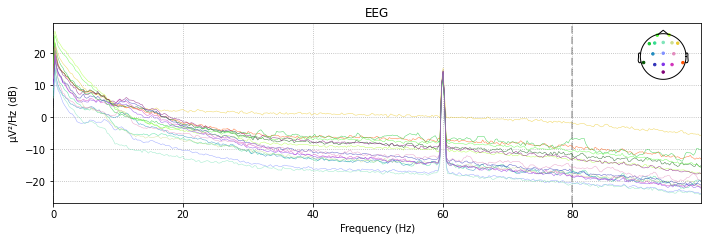

In [6]:
raw.plot_psd(fmax=100);

The PSD shows a clear spike at 60 Hz, which is the frequency of AC electrical service in Canada, where the data was recorded. This is the electromagnetic interference mentioned above.

The PSD also shows a typical property of human EEG (and many other kinds frequency spectra), known as the **1 / *f*** property. That is, power is highest at the lowest frequencies, and drops off with increasing frequency. The dropoff is not linear (a diagonal line), but rather decreases at approximately 1 divided by the frequency. 

The vertical dashed line shows the low-pass cutoff that was used during data acquisition. This information was stored in the EEG header file, and read by MNE when the data was imported.

### Filter the raw data

We need to chain the `.copy()` and `.filter()` methods because by default, the `.filter()` method modifies the raw data in-place, rather than creating a new, filtered copy of the data. This is sensible for managing the memory used, but can create problems if we want to change the filter settings and redo the filtering step. 

All of the parameters used for filtering were defined at the top of this notebook.

In [7]:
raw_filt = raw.copy().filter(low_cut, hi_cut,
                             l_trans_bandwidth = l_trans_bandwidth,
                             h_trans_bandwidth = h_trans_bandwidth,
                             filter_length=filter_length,
                             method=filter_method)

### Plot the frequency spectrum of the filtered data


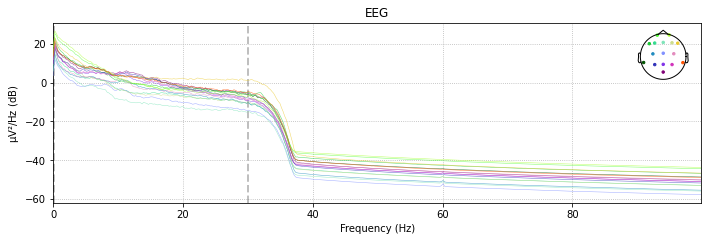

In [8]:
raw_filt.plot_psd(fmax=100);

The effects of our low-pass filter are quite evident — in comparison to the pre-filtering PSD, there is a dramatic drop in power above our 30 Hz cutoff (note that the dashed line has moved to reflect our new low-pass cutoff). The spike at 60 Hz is gone (actually it's still there, but very small), because the filtering virtually eliminated this noise from the data. 

The effects of the high-pass filtering are much harder to see, since the scale is linear from 0–100 Hz, but our cutoff of 0.1 Hz was very close to zero. If we set `fmax` to 10 we can see the effects of the high-pass cutoff more clearly:

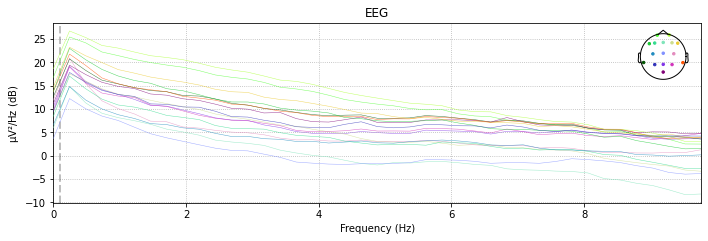

In [9]:
raw_filt.plot_psd(fmax=10);

Note that for both the high- and low-pass filters, the power does not drop of sharply right at the cutoff frequency we specified. Rather, there is a **roll-off** — a range of frequencies over which the power gradually decreases. The shape of the roll-off is a property of the filter that is determined by its parameters, and some roll-off is a necessary feature of any filter if aftifacts are to be avoided. Again, this is a deep topic that we won't delve into here, but in general it is useful to remember the adage that *precision in the frequency domain is inversely related to precision in the time domain*. In other words, if we use a sharper frequency cutoff, we are likely to induce larger artifacts in the data, when we view the filtered data in the time domain. 

### Visualizing the effects of filtering in the time domain

Below we plot 5 s of data, comparing the raw and filtered versions.

#### Unfiltered

Note the high frequency noise in virtually all channels — the oscillations that occur very rapidly. This is particularly large in channel F8. This is primarily 60 Hz line noise. 

Channels F8 and Fp2 show low frequency noise as well — these are the slow drifts up and down seen in these channels.

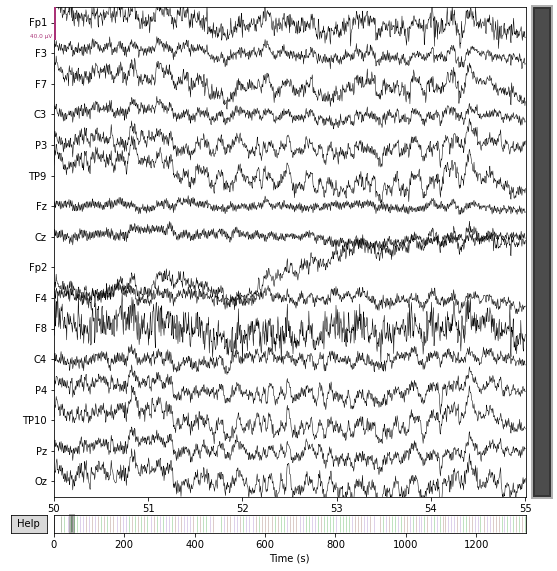

In [10]:
raw.plot(start=50, duration=5);  # times are in seconds

#### Filtered

The plot below shows the same sample of data after filtering. The high frequency noise is gone. The low-frequency noise is perhaps a bit reduced, but not eliminated. This is because our high-pass filter setting was 0.1 Hz, which means that only frequencies below 1 cycle per 10 sec would be reduced. These are so slow that we would not even see much evidence of them in 5 sec of data. Although we could filter the data with a higher high-pass cutoff (e.g., 1 Hz instead of 0.1 Hz), this risks inducing artifacts into the data ([Tanner, Morgan-Short, & Luck, 2015](https://doi.org/10.1111/psyp.12437)), so we don't. 

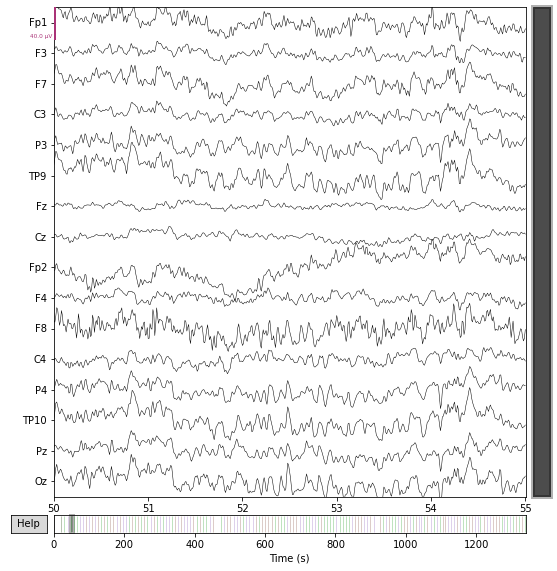

In [11]:
raw_filt.plot(start=50, duration=5);

## Artifacts in EEG Data

Recall that the term **artifact** in EEG refers to any noise in the data that can be attributed to a specific source. So eye blinks, eye movements, and muscle contractions are all types of artifacts. It is important to remove these from the data, to increase our confidence that the results we ultimately interpret are actually due to brain activity, and not these other sources.

Common physiological artifacts, including eye blinks, eye movements, and muscle contractions, have highly characteristic properties in time and frequency. Examples of each are shown below:

### Eye blink

There are a series of several eye blinks in the data below, the first at 242 s. You can see that the size of eye blink artifacts are typically on the order of 10x as large as ongoing EEG, which is why they are such a problem. 

<img src='images/eog_blink.png' width=400>

Because the artifact originates at the eyes, is is picked up most strongly by the electrodes on the forehead, Fp1 and Fp2, as well as other frontal electrodes (the ones whose labels start with *F*, though much smaller). The electrical potential sharply increases, then decreases, over a period of about 250-300 ms for a typical blink. The artifact actually *inverts* at more posterior electrodes, for example at TP9 and TP10 in the figure above. These are the characteristic properties of an eye blink artifact, which can be used to identify them.  

### Eye movements

The neurons in the retina are organized in a highly oriented fashion, such that they form an electrical **dipole** — a source with positive and negative poles. This is exactly the kind of electrical source that EEG is good at detecting. As long as the eye's position doesn't change, the diploe created by the retina doesn't affect EEG recordings, because it is constant (not changing). However, as the eye moves to look at different locations in space, the dipole moves, and this is detected by the electrodes on the scalp. When they eyes move to the left or right, the effect on EEG electrodes is that the electrical potential will increase at frontal electrodes on one side of the head, and decrease on the other side. Which side becomes more positive or negative depends on the direction of the movement. 

An example of a horizontal eye movement is shown in the figure below, overlapping the time where the vertical green line is shown (this line is an event marker, but this is irrelevant for our present purposes). At electrodes Fp1 and Fp2, the artifact looks very similar to a blink. However, note how there is a roughly "square wave" effect at electrodes F7 and F8 (and to a lesser extent, at F3 and F4), and that this goes positive at F7/F3, and negative at F8/F4. This is the hallmark of a horizontal eye movement artifact. In the example below, the horizontal eye movement is followed by two blinks. We can tell these are blinks because the polarity (direction of change) at both F7 and F8 is the same (positive/upward).

<img src='images/eog_horiz.png' width=200px>

### Muscle contractions

In the figure below, note the increase in high frequency activity starting just after 872 s, especially at channels F3, F7, and TP9. This is typical of a muscle contraction, likely of the face and/or neck. Brief contractions like this are usually not a problem, but if the participant is tense throughout the experiment, or at least for extended periods, then this high frequency noise can make it more challenging to detect ERPs. Muscle contractions typically have a fairly broad frequency range, from about 20-40 Hz, which means that this artifact will be present even after the data is band-pass filtered.

<img src='images/eeg_muscle.png' width=400px>

## Artifact removal with Independent Components Analysis (ICA)

ICA is a *blind source separation* algorithm. In other words, it can take a complex signal and separate it into mathematically independent *components*. Note that the term "components" here is not used in the sense of ERP components (like the N170 or N400) that were discussed earlier. Rather, in ICA *components* are the individual underlying signals that were mixed together during recording. So for example, in EEG each electrode will record a mixture of brain activity (which itself may comprise multiple sources within the brain, such as the activity of different brain areas) and noise (including physiological and non-physiological artifacts). ICA is capable of separating EEG from artifacts (and separating different types of artifacts) because, over time and across all of hte recording electrodes, each signal with a different source will have different spatio-temporal properties. 

A nice example of using ICA, that may seem a. bit less abstract than EEG data, is audio recording. Imagine that we have two people in a room having a conversation, and there is background noise in the room such as from the ventilation system. If we have a single microphone in the room, all three signals (person A, person B, and the ventilation) will be mixed in the recording and it will be hard to separate them. However, if we have three microphones at different locations in the room, then each will pick up all three sound sources, but to different degrees depending on the location of each microphone. ICA can use the audio from all three microphones to find independent sources in the data (i.e., person A, person B, and the ventilation), based on how the sounds from each person, and the ventilation, differ systematically across the three microphones. But this only works because we have multiple independent sources (the microphones) sampling the data from different locations.

Likewise with EEG, it is necessary to have multiple electrodes (the sources) to run ICA. The maximum number of ICA components  that can be derived from a data set is equal to the number of electrodes (channels) we have. However, in practice the number of independent sources in the data is lower than the number of electrodes, and we can limit the number of ICA components accordingly, as we'll see below. 

In EEG, ICA has become widely used for artifact identification and removal. This is because it does a very good job of identifying ocular artifacts (blinks and eye movements), and also usually muscle artifact as well. Moreover, because the different ICA components are mathematically independent of each other, having identified which components are "noise" (such as blinks), we can remove these components from the data without affecting the other components. This means we can effectively remove the effects of ocular artifacts from the data, while preserving the EEG signals. This is usually preferable to older approaches, such as removing any trial containing an artifact from the data set completely. ICA allows us to remove artifacts while keeping all of the trials. 

### Filter data for ICA

ICA is very good at capturing features of the data that explain the most *variance*. Recall that variance, statistically speaking, is any deviation from the mean. Blinks and eye movements are well-captured by ICA because they are so much larger than EEG, and so they contain a lot of the variance in the EEG recordings. Likewise, low-frequency drift in the data explains large amounts of variance, because of the 1/f property of EEG data discussed earlier — the lowest frequencies contain the most power. For this reason, ICA works best on data that has more low-frequency power removed than the data that we ultimately want to analyze. So we will filter the data for ICA with a 1 Hz high-pass cutoff, rather than a 0.1 Hz cutoff as we used above. A useful property of ICA is that we can compute ICA based on a more-filtered version of the data, identify the artifacts based on this, and then apply the same ICA decomposition (i.e., how ICA breaks the data down into components) to the data that were filtered as we wanted for ERP analysis. Below we do this, running the same filtering command as we did earlier, except with a different high-pass (low frequency) cut-off:

In [12]:
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power

raw_ica = raw.copy().filter(ica_low_cut, hi_cut,
                             l_trans_bandwidth = l_trans_bandwidth,
                             h_trans_bandwidth = h_trans_bandwidth,
                             filter_length=filter_length,
                             method=filter_method)

### Clean data for ICA

Besides filtering out low-frequency noise, we want to identify any sections of EEG data that have excessive noise. This can occur, for example, if a participant scratches their head during a recording, or sneezes, or for various other reasons. These "one-off" sources of noise can create large artifacts in the data. Since large amplitudes mean high variance, the presence of these artifacts can interfere with ICA's finding more frequent artifacts like blinks — since blinks are larger than EEG data, but smaller than these one-off sources of noise. Another possible source of noise in EEG data is bad channels — electrodes taht for some reason produced poor-quality data. Sometimes, and electrode is broken, or for some reason doesn't have a good connection to the scalp, and in that case the data from it may contain no EEG signal whatsoever, or at least excessive noise. For bad channels, the best approach is to identify them and mark them as "bad" in the data set (MNE's data objects have an attribute `bads` to keep track of these). Channels marked as "bad" will be ignored by MNE functions and, after preprocessing of good channels, the data from bad channels can be interpolated from the other (good) electrodes around it. 

It is possible to go through the data manually to identify and remove these large artifacts and bad channels, but fortunately there is a companion package to MNE, called `autoreject`, that will do this for us. We'll import the functions we need from this package here, along with a couple of other functions we'll need. Normally it's good practice to import all the packages you'll need at the top of a notebook, but we're doing it here for the purposes of explaining which packages are being used for what purposes.

In [13]:
from autoreject import Ransac, get_rejection_threshold, AutoReject
from mne.viz.ica import _prepare_data_ica_properties
from scipy.stats import zscore

ICA likes to work with segments of data, rather than the continuous raw data. We call segments of EEG data **epochs**, a word which means "a period of time". Typically when talking about ERPs, *epochs* refers to the segments of data that are time-locked to experimental events of interest. Here, however, we use the term more generically to refer to any segment of EEG data. So here we will segment the entire raw data recording into a series of 1 s segments, and save these as `epochs_ica`.

In [14]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Next we run an MNE function that will look at the data and automatically determine a threshold to use to find sections of the data that are "excessively" noisy:

In [15]:
### Find appropriate rejection threshold to eliminate noisy trials from ICA fitting
reject = get_rejection_threshold(epochs_ica);

Estimating rejection dictionary for eeg


Then we run a function from `autoreject` called `Ransac` that will automatically identify and remove any excessive noise and/or bad channels. RANSAC is an acronym for [*random sample consensus*](https://en.wikipedia.org/wiki/Random_sample_consensus), an algorithm designed to detect outliers in data ([Fischler & Bolles, 1981](https://doi.org/10.1145%2F358669.358692)), that has been adapted for EEG data by Jas and colleagues (2017) and implemented in the [`autoreject`](https://autoreject.github.io) Python package. Running this involves two steps: 
1. Create a `Ransac` object with the parameters (kwargs) that we want to use
1. `fit` this object to the data — which effectively runs the algorithm on the data, using the parameters set in step 1

This may seem overly complex — why define and object and then apply a `.fit()` method, rather than having a method that we just apply to the data in a single step/line of code?  

The reason relates to the nature of object-oriented languages. By creating a `Ransac` object, we have a data structure — separate from the EEG data itself — that stores important information about this preprocessing step. After we fit the `ransac` object to the data, the object contains the values that were estimated from the data. In other words, running `.fit()` on the data *doesn't change the data itself*, only the `Ransac` object. That way, this step is "non-destructive" in the sense that if we aren't happy with the results, we don't need to worry about re-loading our data — we can simply modify parameters of the `Ransac` object and re-fit it. We'll do this for ICA as well; later in the course we'll see that this is actually the primary way in which machine learning and statistical models are fit to data sets in Python. 

Note that this is computationally expensive and will take a little while to run (anywhere from 10 s to several minutes, depending on your computer system).

In [16]:
# Create Ransac object with desired parameters
ransac = Ransac(random_state=ica_random_state, verbose=False)
# Fit Ransac object to data
ransac.fit(epochs_ica);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


Critically, at this step the only information we want from Ransac is which channels should be marked as "bad", if any. This is stored in an attribute of the object named `.bad_chs_`, which we will now copy to the `bads` attribute of the data set we're going to apply ICA to:

In [17]:
epochs_ica.info['bads'] = ransac.bad_chs_

### Fit ICA to data

Next we create an `ICA` object, as we did before for Ransac, setting the parameters we desire, and then fit it.

The first parameter that we want to specify is the number of independent components we want. Recall that by default, ICA will compute as many components as there are channels in the data, but this is typically more than is necessary or useful. The `n_components` parameter of ICA can be specified in one of two ways. One is to provide an integer specifying the actual number of components desired. An optimal number for this, however, is hard to know in advance. The other way is to specify a floating point number ≤ 1, which represents the percentage of data that the ICA components should, collectively, explain. Here we use `.99`, which means we want as many independent components as needed to explain 99% of the variance in the data. Typically this is a good value to use.

The other parameter is `random_state`. We use this because ICA is an *iterative* algorithm that starts with a set of random parameters, and then over a series of fitting steps computes the optimal values of these parameters. The set of random parameters it starts with determines the results to some extent. That is, if you fit ICA repeatedly to the data, you will generally get very similar, but not identical, results each time, because of the different random starting points. By specifying a `random_state`, we ensure that the same "random" parameters are used each time, meaning that our results will be replicable. The value 42 is used by convention, because it is the "Answer to the Ultimate Question of Life, the Universe, and Everything" in *The Hitchhiker's Guide to the Galaxy* (Adams, 1979).

In fitting ICA to the data, we include a couple of other parameters, which were defined earlier. `reject` comes from `get_rejection_threshold`, and `tstep` is the 1 s intervals that we segmented our data in. 

In [18]:
# ICA parameters
ica_random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=ica_random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

Method,fastica
Fit,47 iterations on epochs (671340 samples)
ICA components,11
Explained variance,99.1 %
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


The `.fit()` step produces the output you see above, showing some of the resulting parameters stored in `ica`.

### Visualize ICA components

Every ICA component is a signal that varies over time, that has a "weighting" at each channel - reflecting how strongly present that component is in that channel. In other words, the time course of a component is the same at all electrodes, but it is bigger at some, and smaller at others. 

We can visualize each component as a **scalp topography map**, showing where on the scalp the component is largest. *Topo maps*, as they are often abbreviated, are a different way of visualizing EEG data than we've seen before. Whereas previously we've viewed EEG as electrical potential over time, topo maps show how the potential are distributed spatially, at a specific point in time (or averaged over a period of time). The maps use the red-blue colour map where red is positive, blue is negative, and white is zero. "Positive" and "negative" in ICA topo maps can reflect cases where a component has the same shape over time, but opposite (negative vs. positive) electrical polarity at different scalp locations. This can be seen, for example, in `ICA004` below, which reflects the opposite polarities induced by horizontal eye movements.

Indeed, in the figure below we can see that a few components are likely ocular artifacts, because they weight most heavily around the front of the head (the top of each subplot, where the nose is drawn). In particular, `ICA003` is likely blink artifact, and `ICA004` is likely horizontal eye movement. `ICA007` may be eye movement as well, however it does not show opposite polarity on either side of the head as we would expect from a horizontal (sideways) eye movement. Many of the other components, such as `ICA003`, `ICA005`, `ICA008`, and `ICA009`, likely reflect actual brain activity. For example, `ICA003` weights most heavily over the occipital lobe, and likely reflects visual cortex activity. The scalp topography of `ICA005` is consistent with the N400 component, which was predicted in this language processing study (we'll explain the experiment that generated this data a bit later).

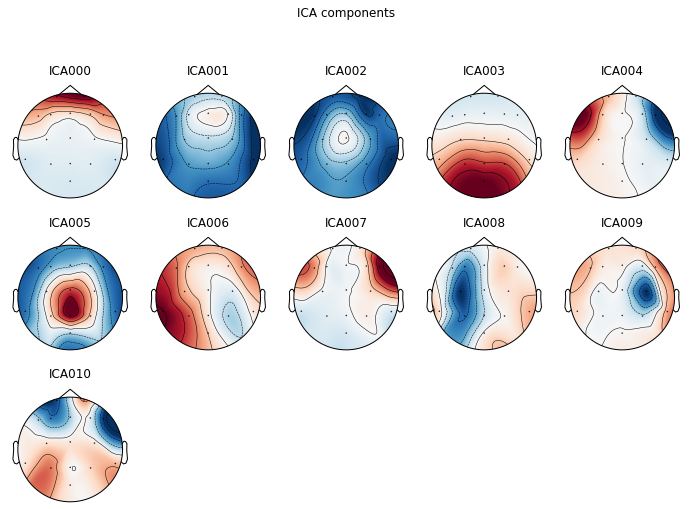

In [19]:
ica.plot_components();

### Plot IC properties

We can use the `.plot_properties()` method of the ICA class to view more details of each component. Moving clockwise from top left, the four subplots for each component are:
- topo map
- raster plot of how the component weights on each trial. Artifacts like blinks should appear as "streaks" lasting about 200-300 ms, on relatively few trials. Components reflecting brain activity are typically present across many epochs (although remember that these data are segmented into 1 s epochs across the entire raw data set, so we would not expect to see time-locked activity here)
- Variance of the component, across channels and time. The *x* axis is epochs (effectively, time across the experiment), and the *y* axis is the variance of the component across channels. Noise typically manifests as high variance on a low number of trials, and low variance on most trials, or lots of variability in the values on the *y* axis over epochs. True brain activity usually appears as consistently similar — and low — variance across epochs. 
- The PSD (phase spectral density) of the component. EOG (eye) artifacts will typically have a peak at the low frequency end of the spectrum (the left side of teh *x* axis), and muscle artifact will tend to show increasing power at the high end of the frequency spectrum (the right side of the *x* axis).  

With this in mind, `ICA000` is very characteristic of a blink artifact. The scalp topography i sweighted most heavily at the electrodes right above the eyes (where blinks are most strongly detected) and the raster plot shows stresks on relatively few trials. The third plot shows high variance on a few trials, and the PSD is largest at teh low end of teh spectrum. 

`ICA004` shows similar properties, except that its scalp topography is maximal over the left and right anterior scalp locations, with opposite polarities (showing as blue vs. red). This is characteristic of horizontal eye movements.

Although we suggested above that `ICA007`'s scalp topography was somewhat consistent with eye movements The properties plot below of this component is not as consistent with eye movements. Unlike `ICA004`, its polarity doesn't differ between left and right sides of the head, and the raster plot does not show the same clear events (streaks) over a few hundered milliseconds on a few trials - it looks weak across all trials. 

Fortunately, as we'll see below, we don't need to make subjective judgment calls about which ICA components to reject (although some researchers do use visual inspection, based on extensive training and experience). However, it's worth knowing what artifacts look like, so that you can check the results of any automated approach to ICA component selection/rejection against your understanding of how they should work.

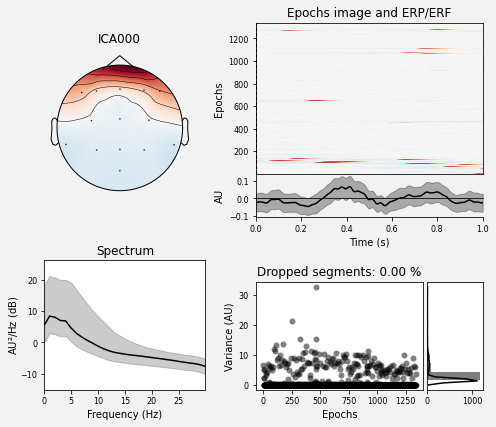

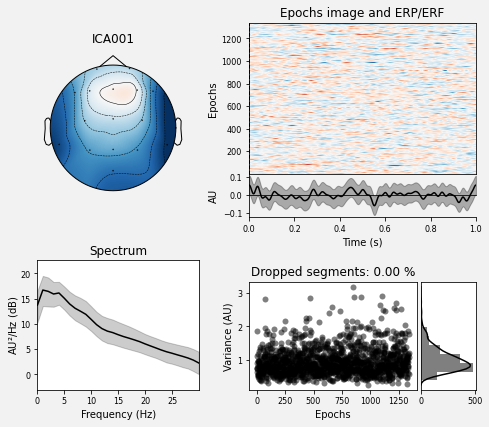

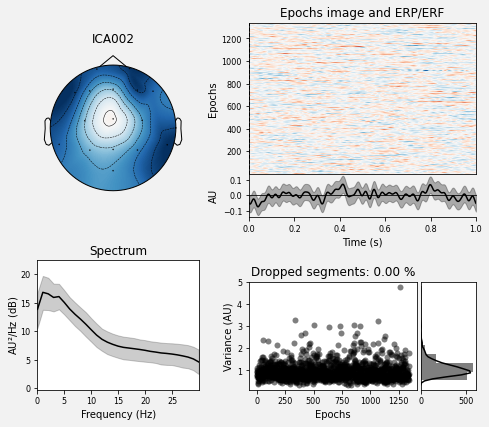

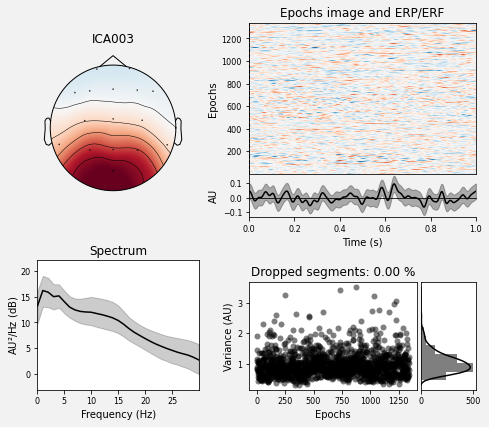

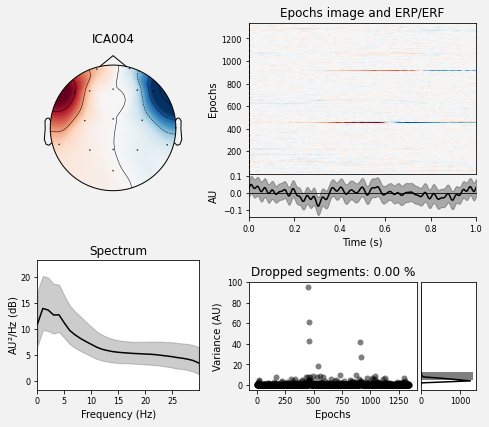

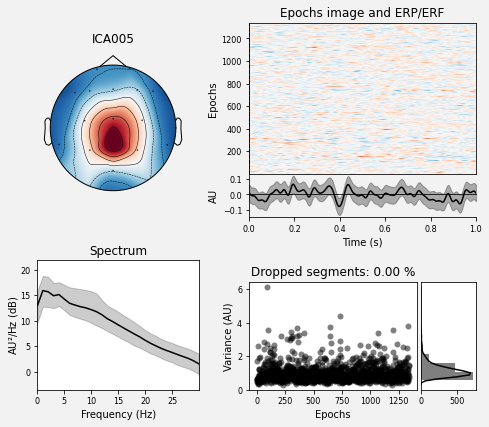

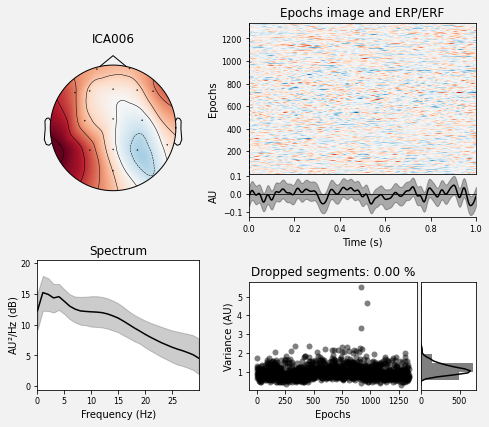

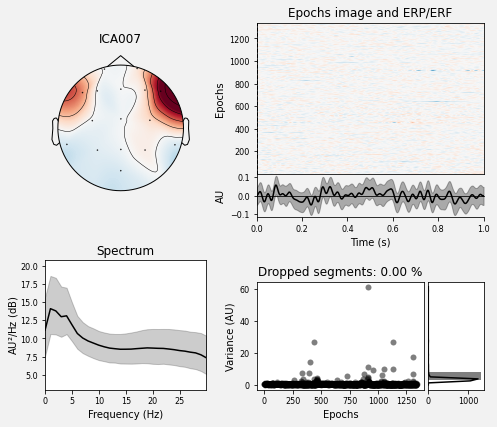

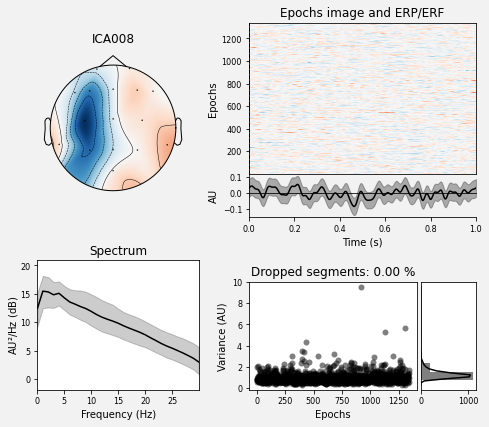

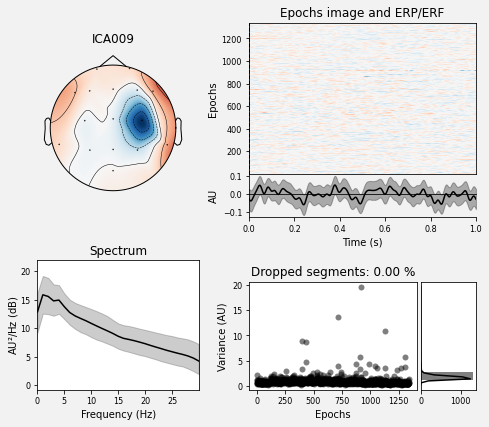

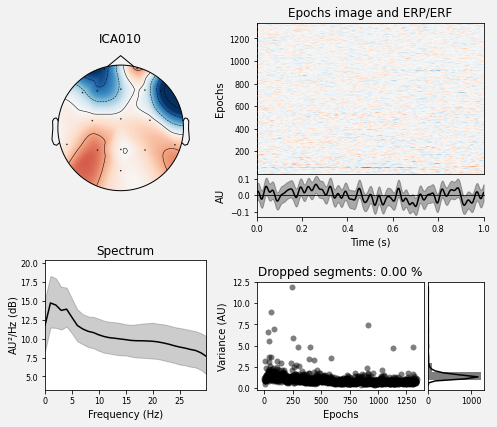

In [20]:
ica.plot_properties(epochs_ica, picks=range(0,ica.n_components_), psd_args={'fmax': hi_cut});

### Identify EOG artifacts from ICA components

In [21]:
ica_z_thresh = 2.3 
raw_ica.set_channel_types({'Fp1':'eog', 'Fp2':'eog', 'F7':'eog', 'F8':'eog'})
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, threshold=ica_z_thresh)
ica.exclude = eog_indices

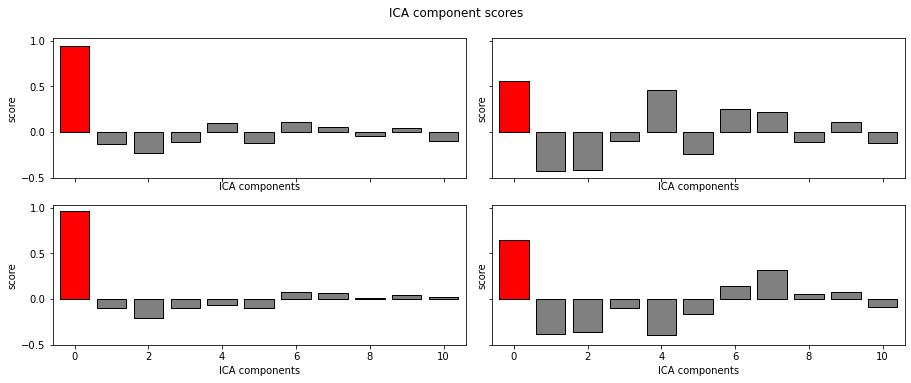

In [22]:
ica.plot_scores(eog_scores);

#### Segment filtered raw data into epochs for final analysis

In [23]:
epochs = mne.Epochs(raw_filt,
                    events_new, event_id_new,
                    tmin, tmax,
                    baseline=baseline, detrend=detrend,
                    reject=reject, flat=None,
                    preload=True
                   )

NameError: name 'events_new' is not defined

### Apply ICA correction to epochs

In [ ]:
epochs_postica = ica.apply(epochs.copy())
epochs_postica.info['bads'] = ransac.bad_chs_
epochs_postica = epochs_postica.interpolate_bads()

### Apply AutoReject to clean epochs

In [ ]:
ar = AutoReject(n_jobs=n_jobs, random_state=ica_random_state, verbose=False)
epochs_clean = ar.fit_transform(epochs_postica)
# Re-reference to average of all channels, now that they are cleaned
epochs_clean.set_eeg_reference(ref_channels='average');

### Report on how much was rejected

In [ ]:
rm_epochs = epochs_postica.selection.shape[0] - epochs_clean.selection.shape[0]
pct_epochs = rm_epochs / epochs_postica.selection.shape[0] * 100
print('n epochs removed: ' + str(rm_epochs)
      + '\nrepresenting ' + str(round(pct_epochs, 2)) + ' % of data')

# Save log of rejections
rej_log_list.append(pd.DataFrame({'Subject':subject,
                                  'n Trials Rej':rm_epochs,
                                  '% Trials Rej':round(pct_epochs, 2),
                                  'n Chans Fixed':len(epochs_ica.info['bads']),
                                  'n ICs removed':len(ica.exclude)
                                  }, index=[0])
                     )

### Save cleaned epochs

In [ ]:
epochs_clean.save(epochs_fname, overwrite=True)

fig = epochs_clean.average().plot(spatial_colors=True, show=False);
plt.show()

rej_log = pd.concat(rej_log_list, ignore_index=True)
rej_log.to_csv(log_path + p_id + '_rej_log.csv')